# SNAP_FINANCE BI ASSESSMENT

Below cells are used to import libraries, packges and install packages that does not already exist

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine #to connect PostgreSQL
from dotenv import load_dotenv
import os


In [5]:
%pip install psycopg2-binary #to connect PostgreSQL
%pip install python-dotenv #to load .env files

Note: you may need to restart the kernel to use updated packages.


Importing excel_file datasets from sample_datsets and performing all necessary Data cleaning, Validations and ETL functions on the data

In [6]:
#loading excel file 

#Excel object created
xls = pd.ExcelFile('Desktop/DE interview prep/Interview prep - Company specific research and Behavioral/Snap Finance/sample_datasets.xlsx')

In [7]:
#using the excel object, dataframes are created for each table using .parse method
#.parse() is preferred over read_excel() because it is much simpler with .parse() to read each sheet as a table

applications_df = xls.parse("applications")
customers_df = xls.parse("customers")
stores_df = xls.parse("stores")
marketing_df = xls.parse("marketing")

Performing Pre-check

In [8]:
applications_df.head()

,Unnamed: 0,application_id,customer_id,store,submit_date,approved,approved_date,approved_amount,dollars_used,lease_grade
0,0,QF3MF29MZL80KPRE,755880622768,store_74,2022-11-18 04:17:26,False,NaT,NaN,NaN,C
1,1,X268IFWKNYXB99QI,332145121573,store_50,2022-04-17 00:46:48,False,NaT,NaN,NaN,D
2,2,R9C3GKI5H8HUS5D3,144890296478,store_101,2023-12-17 12:10:12,True,2023-12-19 12:10:12,3294.0,2318.0,A
3,3,FBJWF9S7OP4JR3GH,419615144299,store_54,2023-09-30 08:59:46,False,NaT,NaN,NaN,F
4,4,BKVGSPWKJ2O98AJ9,848253698374,store_137,2022-10-03 00:20:29,True,2022-10-03 00:20:29,2874.0,NaN,B


In [9]:
customers_df.head()

,Unnamed: 0,customer_id,DOB,first_name,last_name,email,phone_number,language,income,title,campaign
0,0,755880622768,1997-11-11,Douglas,Ramirez,vgrant@example.net,001-304-226-7086x106,Spanish,13083,Ambulance person,13
1,1,332145121573,1997-11-30,Mary,Cruz,tyler38@example.com,270-279-7276,English,13143,IT sales professional,0
2,2,144890296478,1997-12-22,Bryan,Anderson,stevengreene@example.org,(828)977-0809,English,7522,Licensed conveyancer,8
3,3,419615144299,2005-05-18,Christine,Murray,christinesummers@example.org,218-169-1692x1171,Spanish,8963,Archivist,13
4,4,848253698374,2008-03-14,Jared,Mayer,suttonjessica@example.com,669-062-7993x616,English,2771,Social researcher,0


In [10]:
stores_df.head()

,Unnamed: 0,store,start_dt,state,size,industry
0,0,store_0,2020-12-17 17:47:23,Iowa,Medium,Healthcare
1,1,store_1,2020-08-02 14:09:39,Louisiana,Small,Retail
2,2,store_2,2021-05-28 14:15:26,Tennessee,Medium,Transportation
3,3,store_3,2020-01-01 15:30:22,Minnesota,Medium,Retail
4,4,store_4,2020-08-24 15:04:57,Maine,Small,Education


In [11]:
marketing_df.head()

,Unnamed: 0,id,name,spend,start_date,end_date
0,0,0,No Campaign,0,NaN,NaN
1,1,1,Google Ads,4798711,2022-01-26,2027-07-03
2,2,2,Facebook Ads,704391,2023-09-04,2029-12-28
3,3,3,Instagram Ads,1042189,2023-01-22,2029-05-23
4,4,4,Twitter Ads,3996752,2023-05-17,2028-05-08


In [12]:
#Removing all unnamed columns and extra whitespaces from column names - created by default by Excel, using a function

def clean_columns(df):
    return df.loc[:, ~df.columns.str.contains('^Unnamed')].rename(columns=lambda x: x.strip())
#two things are happening here, regex is used to identify columns named 'unnamed' 
#.loc will select all columns that do not match these conditions and then rename them after removing whitespaces with the help of strip

applications_df = clean_columns(applications_df)
customers_df = clean_columns(customers_df)
stores_df = clean_columns(stores_df)
marketing_df = clean_columns(marketing_df)

In [13]:
# moving on to dates
# in each dataframe, the dates are converted from String type to DATE TIME 
# ensures one single format across all tables

applications_df["submit_date"] = pd.to_datetime(applications_df["submit_date"], errors="coerce")
applications_df["approved_date"] = pd.to_datetime(applications_df["approved_date"], errors="coerce")
customers_df["DOB"] = pd.to_datetime(customers_df["DOB"], errors="coerce")
stores_df["start_dt"] = pd.to_datetime(stores_df["start_dt"], errors="coerce")
marketing_df["start_date"] = pd.to_datetime(marketing_df["start_date"], errors="coerce")
marketing_df["end_date"] = pd.to_datetime(marketing_df["end_date"], errors="coerce")


#here coerce ensures that, if there is any invalid date entry, they become NaT (Not a Time)

In [14]:
#pre-checks on approved column and dollars_used column to see if flags need to be created


print("Unique values in 'approved':", applications_df["approved"].unique())
print("Data type of 'approved':", applications_df["approved"].dtype)


Unique values in 'approved': [False  True]
Data type of 'approved': bool


No flag needed for approved column

In [15]:
print("Null count in 'dollars_used':", applications_df["dollars_used"].isnull().sum())
print("Non-zero usage count:", (applications_df["dollars_used"].fillna(0) > 0).sum())
print("Data type of 'dollars_used':", applications_df["dollars_used"].dtype)

Null count in 'dollars_used': 49261
Non-zero usage count: 16274
Data type of 'dollars_used': float64


Presence of null columns in dollars_used column indicates that a flagged column is a must which can be used later on 

In [16]:
def usage_status(row):
    if row['approved'] and pd.notnull(row['dollars_used']) and row['dollars_used'] > 0:
        return "Used"
    elif row['approved']:
        return "Approved but Not Used"
    else:
        return "Not Approved"

applications_df["usage_status"] = applications_df.apply(usage_status, axis=1)


Handling Nulls and Duplicates

In [17]:
# Check for nulls in each table
null_summary = {
    "applications_nulls": applications_df.isnull().sum(),
    "customers_nulls": customers_df.isnull().sum(),
    "stores_nulls": stores_df.isnull().sum(),
    "marketing_nulls": marketing_df.isnull().sum()
}

# Check for duplicates in key columns
duplicates = {
    "duplicate_applications": applications_df["application_id"].duplicated().sum(),
    "duplicate_customers": customers_df["customer_id"].duplicated().sum(),
    "duplicate_stores": stores_df["store"].duplicated().sum(),
    "duplicate_campaigns": marketing_df["id"].duplicated().sum()
}

# Display summary
print("=== NULL SUMMARY ===")
for table, summary in null_summary.items():
    print(f"\n{table}:\n{summary}")

print("\n=== DUPLICATE CHECKS ===")
for key, count in duplicates.items():
    print(f"{key}: {count}")


=== NULL SUMMARY ===

applications_nulls:
application_id         0
customer_id            0
store                  0
submit_date            0
approved               0
approved_date      32779
approved_amount    32779
dollars_used       49261
lease_grade            0
usage_status           0
dtype: int64

customers_nulls:
customer_id     0
DOB             0
first_name      0
last_name       0
email           0
phone_number    0
language        0
income          0
title           0
campaign        0
dtype: int64

stores_nulls:
store       0
start_dt    0
state       0
size        0
industry    0
dtype: int64

marketing_nulls:
id            0
name          0
spend         0
start_date    1
end_date      1
dtype: int64

=== DUPLICATE CHECKS ===
duplicate_applications: 0
duplicate_customers: 0
duplicate_stores: 0
duplicate_campaigns: 0


Since all columns have valid nulls and duplicates - no changes required. Except, the dollars_used and approved_amounts are converted to 0 if null, so that aggregations and visualizations later on in the process are not affected.

In [18]:
# Fill approved_amount and dollars_used with 0s (for math safety)
applications_df["approved_amount"] = applications_df["approved_amount"].fillna(0)
applications_df["dollars_used"] = applications_df["dollars_used"].fillna(0)


performing post checks

In [19]:
applications_df.head()

,application_id,customer_id,store,submit_date,approved,approved_date,approved_amount,dollars_used,lease_grade,usage_status
0,QF3MF29MZL80KPRE,755880622768,store_74,2022-11-18 04:17:26,False,NaT,0.0,0.0,C,Not Approved
1,X268IFWKNYXB99QI,332145121573,store_50,2022-04-17 00:46:48,False,NaT,0.0,0.0,D,Not Approved
2,R9C3GKI5H8HUS5D3,144890296478,store_101,2023-12-17 12:10:12,True,2023-12-19 12:10:12,3294.0,2318.0,A,Used
3,FBJWF9S7OP4JR3GH,419615144299,store_54,2023-09-30 08:59:46,False,NaT,0.0,0.0,F,Not Approved
4,BKVGSPWKJ2O98AJ9,848253698374,store_137,2022-10-03 00:20:29,True,2022-10-03 00:20:29,2874.0,0.0,B,Approved but Not Used


In [20]:
customers_df.head()

,customer_id,DOB,first_name,last_name,email,phone_number,language,income,title,campaign
0,755880622768,1997-11-11,Douglas,Ramirez,vgrant@example.net,001-304-226-7086x106,Spanish,13083,Ambulance person,13
1,332145121573,1997-11-30,Mary,Cruz,tyler38@example.com,270-279-7276,English,13143,IT sales professional,0
2,144890296478,1997-12-22,Bryan,Anderson,stevengreene@example.org,(828)977-0809,English,7522,Licensed conveyancer,8
3,419615144299,2005-05-18,Christine,Murray,christinesummers@example.org,218-169-1692x1171,Spanish,8963,Archivist,13
4,848253698374,2008-03-14,Jared,Mayer,suttonjessica@example.com,669-062-7993x616,English,2771,Social researcher,0


In [21]:
stores_df.head()

,store,start_dt,state,size,industry
0,store_0,2020-12-17 17:47:23,Iowa,Medium,Healthcare
1,store_1,2020-08-02 14:09:39,Louisiana,Small,Retail
2,store_2,2021-05-28 14:15:26,Tennessee,Medium,Transportation
3,store_3,2020-01-01 15:30:22,Minnesota,Medium,Retail
4,store_4,2020-08-24 15:04:57,Maine,Small,Education


In [22]:
marketing_df.head()

,id,name,spend,start_date,end_date
0,0,No Campaign,0,NaT,NaT
1,1,Google Ads,4798711,2022-01-26,2027-07-03
2,2,Facebook Ads,704391,2023-09-04,2029-12-28
3,3,Instagram Ads,1042189,2023-01-22,2029-05-23
4,4,Twitter Ads,3996752,2023-05-17,2028-05-08


Task 1. Calculate the number of applications, number of approved, and the number of used applications and visualize the trend over the submission date.

In [23]:
#Calculating aggregates for each day of the year

day_df = applications_df.copy()
day_df["submit_day"] = day_df["submit_date"].dt.date #using the .dt accessor

day_df = day_df.groupby("submit_day").agg(
    total_applications=("application_id", "count"),
    approved_applications=("approved", "sum"),
    used_applications=("usage_status", lambda x: (x == "Used").sum()) #Only when the case is 'USED' - similar to applying CASE WHEN THEN in SQL
).reset_index()

day_df.head()


,submit_day,total_applications,approved_applications,used_applications
0,2022-01-01,96,46,27
1,2022-01-02,89,47,22
2,2022-01-03,85,35,16
3,2022-01-04,93,53,30
4,2022-01-05,85,37,21


Calculating aggregates for each month of the year

In [24]:
#Calculating aggregates for each month of the year

month_df = applications_df.copy()
month_df = month_df.groupby(month_df["submit_date"].dt.to_period("M")).agg(
    total_applications=("application_id", "count"),
    approved_applications=("approved", "sum"),
    used_applications=("usage_status", lambda x: (x == "Used").sum())
).reset_index().rename(columns={"submit_date": "submit_month"})

month_df.head()


,submit_month,total_applications,approved_applications,used_applications
0,2022-01,2775,1383,660
1,2022-02,2514,1282,628
2,2022-03,2723,1352,686
3,2022-04,2693,1284,649
4,2022-05,2787,1346,672


In [25]:
#Calculating aggregates for each quarter of the year

quarter_df = applications_df.copy()
quarter_df = quarter_df.groupby(quarter_df["submit_date"].dt.to_period("Q")).agg(
    total_applications=("application_id", "count"),
    approved_applications=("approved", "sum"),
    used_applications=("usage_status", lambda x: (x == "Used").sum())
).reset_index().rename(columns={"submit_date": "submit_quarter"})

quarter_df.head()

,submit_quarter,total_applications,approved_applications,used_applications
0,2022Q1,8012,4017,1974
1,2022Q2,8227,4021,2033
2,2022Q3,8274,4105,2025
3,2022Q4,8268,4172,2046
4,2023Q1,8009,4028,1990


Calculating aggregates for the whole year

In [26]:
#Calculating aggregates for the whole year

year_df = applications_df.copy()
year_df = year_df.groupby(year_df["submit_date"].dt.to_period("Y")).agg(
    total_applications=("application_id", "count"),
    approved_applications=("approved", "sum"),
    used_applications=("usage_status", lambda x: (x == "Used").sum())
).reset_index().rename(columns={"submit_date": "submit_year"})

year_df.head()

,submit_year,total_applications,approved_applications,used_applications
0,2022,32781,16315,8078
1,2023,32754,16441,8196


In [27]:
#One reusable plot function

def plot_aggregates(df, date_col, title):
    plt.figure(figsize=(12, 5))
    plt.plot(df[date_col].astype(str), df["total_applications"], label="Total Applications", marker='o')
    plt.plot(df[date_col].astype(str), df["approved_applications"], label="Approved Applications", marker='o')
    plt.plot(df[date_col].astype(str), df["used_applications"], label="Used Applications", marker='o')
    plt.title(title)
    plt.xlabel(date_col.replace("_", " ").title())
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


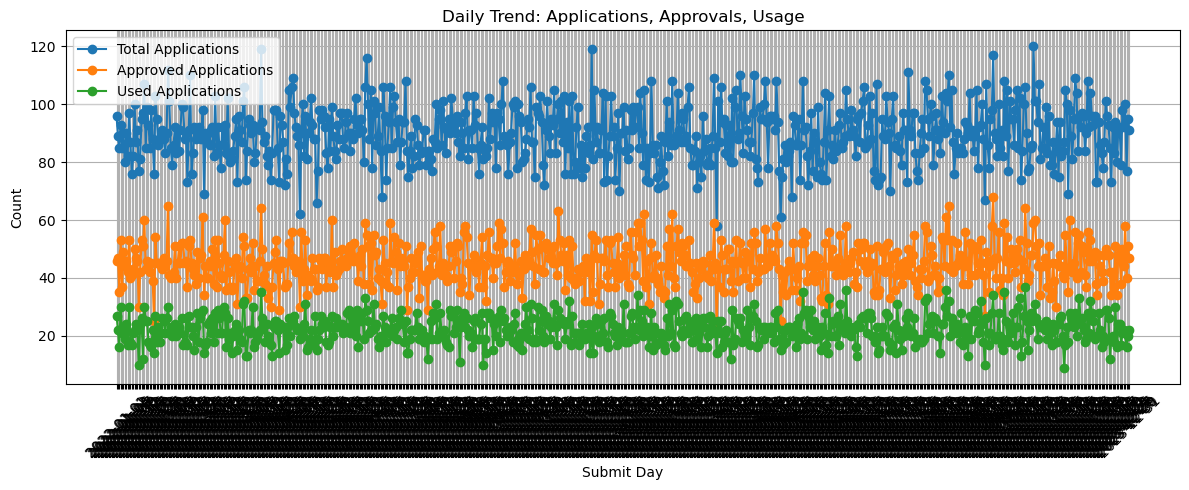

In [28]:
plot_aggregates(day_df, "submit_day", "Daily Trend: Applications, Approvals, Usage")

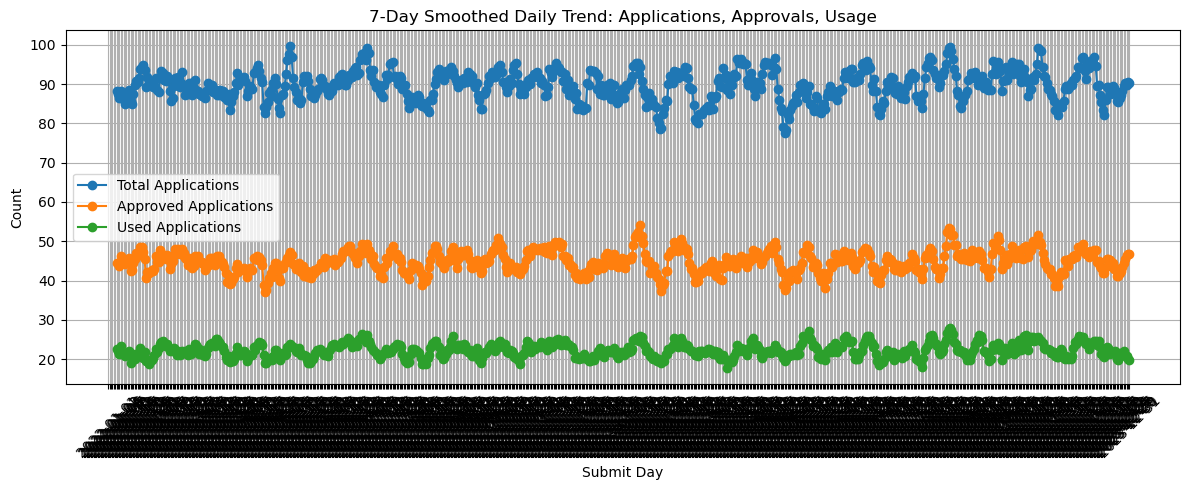

In [29]:
# Apply rolling average to smooth daily values
smoothed_day_df = day_df.set_index("submit_day").rolling(window=7).mean().reset_index()

plot_aggregates(smoothed_day_df, "submit_day", "7-Day Smoothed Daily Trend: Applications, Approvals, Usage")


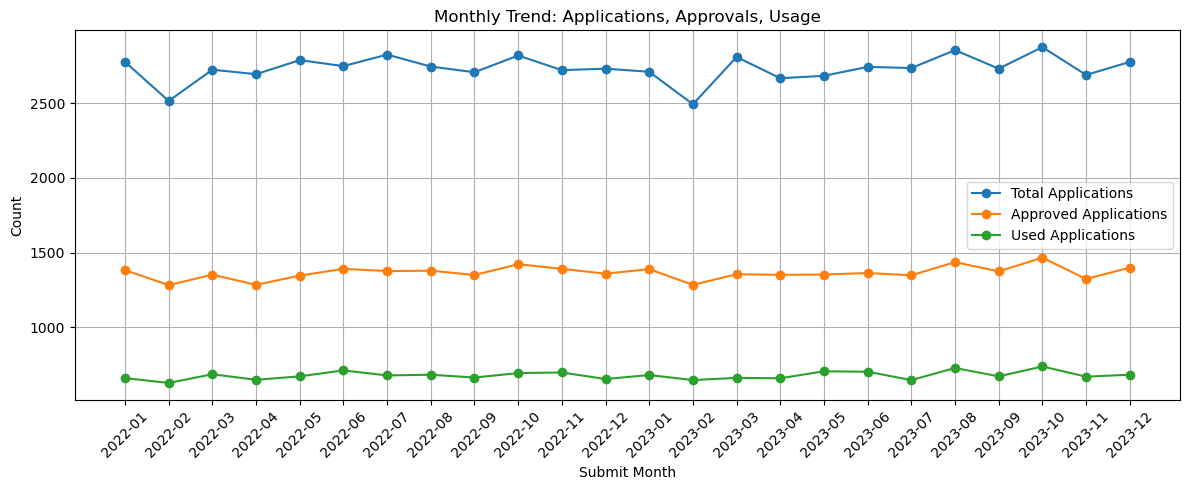

In [30]:
plot_aggregates(month_df, "submit_month", "Monthly Trend: Applications, Approvals, Usage")

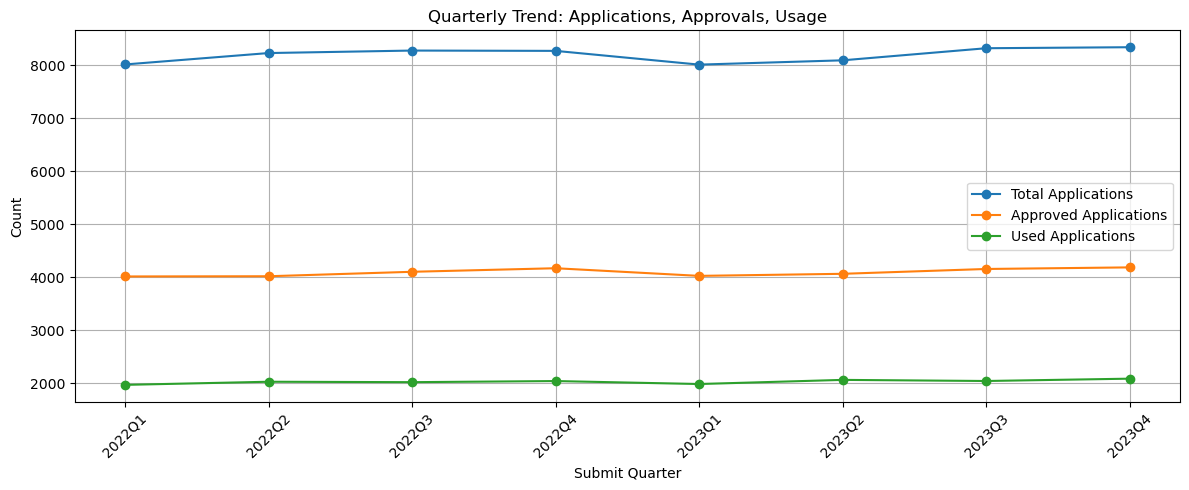

In [31]:
plot_aggregates(quarter_df, "submit_quarter", "Quarterly Trend: Applications, Approvals, Usage")

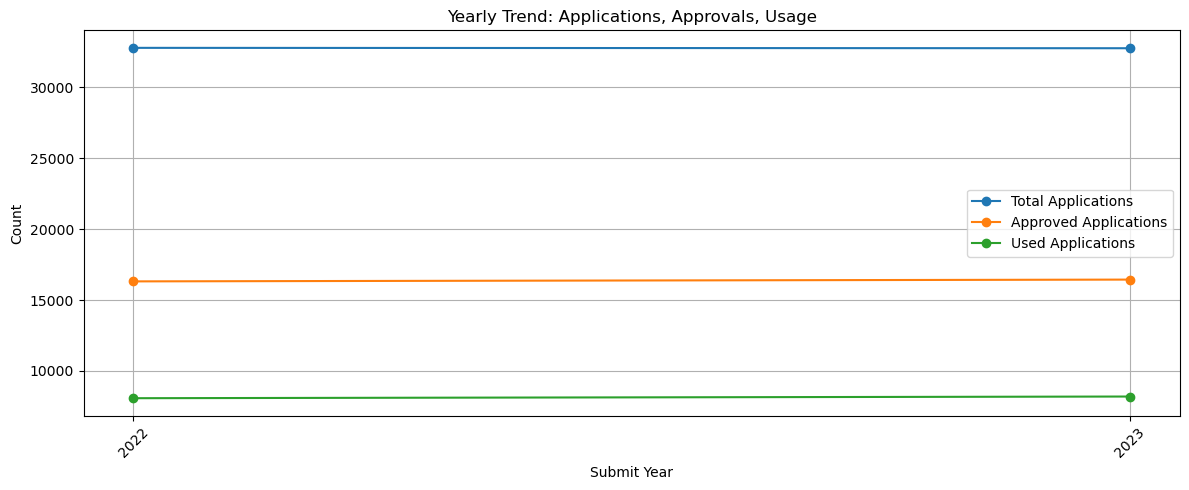

In [32]:
plot_aggregates(year_df, "submit_year", "Yearly Trend: Applications, Approvals, Usage")


-------BUSINESS INSIGHTS-------

THE DAILY TREND

a. Is very crowded and is difficult to analyze. However we observe that although, total applications fluctuate daily but hover tightly around a stable baseline which is 90. Therefore, on an average about 90 applications are raised on a daily basis.

b. Approvals are consistently lower (around 40–60 daily), showing a ~50–60% approval rate.Which to me a good sign showing that the approval mechanism is well managed

c. Used applications are the lowest (20s range), implying a potential drop-off after approval and needs area of improvement.

*Key Takeaways from the daily trend:

a. We likely have a stable lead pipeline indicated by good, consistent number of applications each day

b. Lower actual dollar usage, suggesting either:

    - Customers are approved but don't need the funds immediately.

    - Product/service fit or onboarding issues post-approval



THE MONTHLY TREND


The monthly trends show clear seasonality. Applications start to dip in December through January and start improving in February.



*Key Takeaways:

    - Budgeting cycles (e.g., start-of-year slowdowns) or external economic factors may impact volume.

    - Usage - similar to daily trend, consistently stays around 25% of applications, revealing a persistent usage gap.



QUARTERLY AND YEARLY TREND

No significant insight out of the quarterly and yearly trends, except for a similar dip in applications during the first quarter of the year whith lower usage.

SUGGESTIONS FOR BETTER GTM STRATEGIES:



Recommendation 1: Addressing drop in applications during end of year - “New Year Credit Push” Campaign 

a. Launch a targeted campaign in late December called:

    Ex: An offer to activate credit by Jan 15 and Earn a $25 Reward


Recommendation 2: Addressing Usage Gap - Slight push to start quickly

a. Immediate call-to-action like: 

    Ex: Use within 3 days and receive early usage perks




Task 2 - Calculate the average of the approved amount and the average of the amount used and visualize the trend over the submission date.

In [33]:
applications_df.head()

,application_id,customer_id,store,submit_date,approved,approved_date,approved_amount,dollars_used,lease_grade,usage_status
0,QF3MF29MZL80KPRE,755880622768,store_74,2022-11-18 04:17:26,False,NaT,0.0,0.0,C,Not Approved
1,X268IFWKNYXB99QI,332145121573,store_50,2022-04-17 00:46:48,False,NaT,0.0,0.0,D,Not Approved
2,R9C3GKI5H8HUS5D3,144890296478,store_101,2023-12-17 12:10:12,True,2023-12-19 12:10:12,3294.0,2318.0,A,Used
3,FBJWF9S7OP4JR3GH,419615144299,store_54,2023-09-30 08:59:46,False,NaT,0.0,0.0,F,Not Approved
4,BKVGSPWKJ2O98AJ9,848253698374,store_137,2022-10-03 00:20:29,True,2022-10-03 00:20:29,2874.0,0.0,B,Approved but Not Used


In [34]:
#creating a copy of the applications_df to extract day, month, quarter and year from the date column and add these as seperate columns.

apps_copy = applications_df.copy()

apps_copy["submit_day"] = apps_copy["submit_date"].dt.date
apps_copy["submit_month"] = apps_copy["submit_date"].dt.to_period("M")
apps_copy["submit_quarter"] = apps_copy["submit_date"].dt.to_period("Q")
apps_copy["submit_year"] = apps_copy["submit_date"].dt.to_period("Y")


apps_copy.head()

,application_id,customer_id,store,submit_date,approved,approved_date,approved_amount,dollars_used,lease_grade,usage_status,submit_day,submit_month,submit_quarter,submit_year
0,QF3MF29MZL80KPRE,755880622768,store_74,2022-11-18 04:17:26,False,NaT,0.0,0.0,C,Not Approved,2022-11-18,2022-11,2022Q4,2022
1,X268IFWKNYXB99QI,332145121573,store_50,2022-04-17 00:46:48,False,NaT,0.0,0.0,D,Not Approved,2022-04-17,2022-04,2022Q2,2022
2,R9C3GKI5H8HUS5D3,144890296478,store_101,2023-12-17 12:10:12,True,2023-12-19 12:10:12,3294.0,2318.0,A,Used,2023-12-17,2023-12,2023Q4,2023
3,FBJWF9S7OP4JR3GH,419615144299,store_54,2023-09-30 08:59:46,False,NaT,0.0,0.0,F,Not Approved,2023-09-30,2023-09,2023Q3,2023
4,BKVGSPWKJ2O98AJ9,848253698374,store_137,2022-10-03 00:20:29,True,2022-10-03 00:20:29,2874.0,0.0,B,Approved but Not Used,2022-10-03,2022-10,2022Q4,2022


In [35]:
#Finding the average amount approved and average amount used by customers, per day, per month, per quarter and per year

# Daily average
day_avg_df = apps_copy.groupby("submit_day").agg(
    avg_approved_amount=('approved_amount', 'mean'),
    avg_dollars_used=('dollars_used', 'mean')
).reset_index().round(2)

# Monthly average
month_avg_df = apps_copy.groupby("submit_month").agg(
    avg_approved_amount=('approved_amount', 'mean'),
    avg_dollars_used=('dollars_used', 'mean')
).reset_index().round(2)

# Quarterly average
quarter_avg_df = apps_copy.groupby("submit_quarter").agg(
    avg_approved_amount=('approved_amount', 'mean'),
    avg_dollars_used=('dollars_used', 'mean')
).reset_index().round(2)

# Yearly average
year_avg_df = apps_copy.groupby("submit_year").agg(
    avg_approved_amount=('approved_amount', 'mean'),
    avg_dollars_used=('dollars_used', 'mean')
).reset_index().round(2)


In [36]:
day_avg_df.head()

,submit_day,avg_approved_amount,avg_dollars_used
0,2022-01-01,1503.93,439.15
1,2022-01-02,1567.40,428.21
2,2022-01-03,1256.06,323.88
3,2022-01-04,1981.67,599.39
4,2022-01-05,1374.19,345.55


In [37]:
month_avg_df.head()

,submit_month,avg_approved_amount,avg_dollars_used
0,2022-01,1556.06,388.56
1,2022-02,1608.92,396.03
2,2022-03,1544.92,405.69
3,2022-04,1477.57,388.24
4,2022-05,1474.03,392.04


In [38]:
quarter_avg_df.head()

,submit_quarter,avg_approved_amount,avg_dollars_used
0,2022Q1,1568.86,396.73
1,2022Q2,1511.44,398.14
2,2022Q3,1557.66,396.75
3,2022Q4,1567.95,399.25
4,2023Q1,1568.14,403.07


In [42]:
year_avg_df.head()

,submit_year,avg_approved_amount,avg_dollars_used
0,2022,1551.39,397.73
1,2023,1570.12,405.45


In [43]:
#One reusable plot function

def plot_average_trends(df, date_col, title):
    plt.figure(figsize=(12, 5))
    plt.plot(df[date_col].astype(str), df["avg_approved_amount"], label="Avg Approved Amount", marker='o')
    plt.plot(df[date_col].astype(str), df["avg_dollars_used"], label="Avg Dollars Used", marker='o')
    plt.title(title)
    plt.xlabel(date_col.replace("_", " ").title())
    plt.ylabel("Amount ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

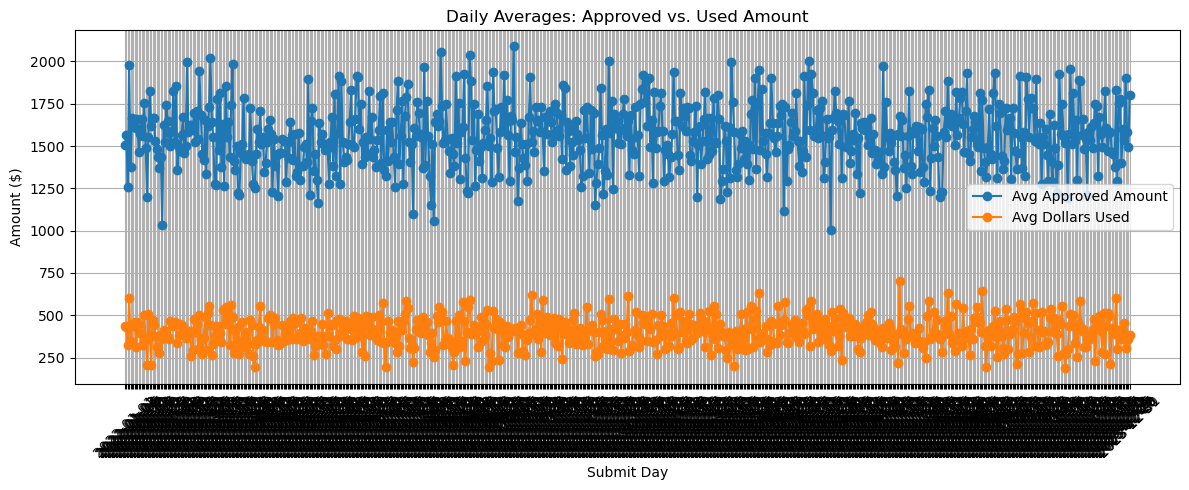

In [44]:
plot_average_trends(day_avg_df, "submit_day", "Daily Averages: Approved vs. Used Amount")

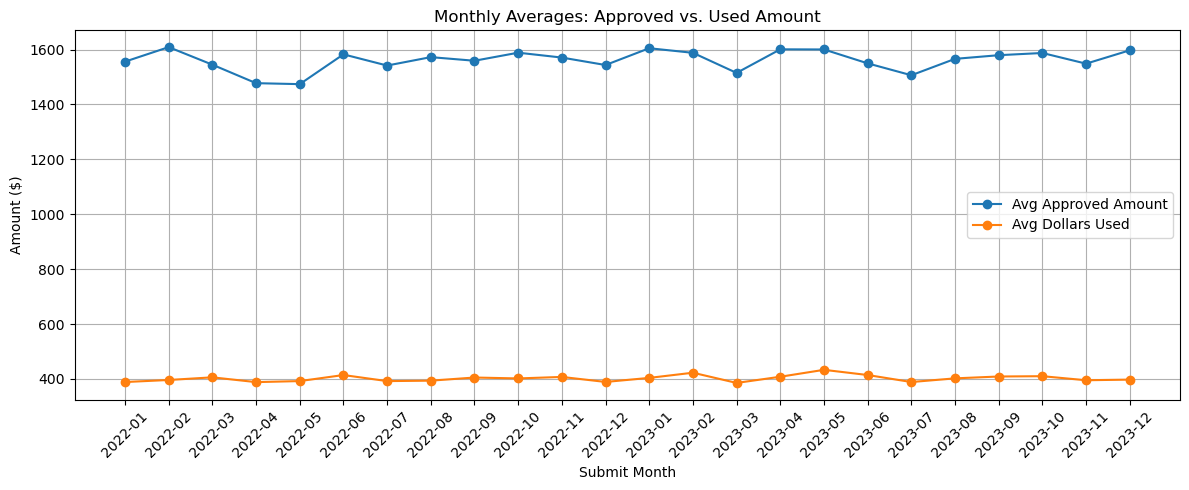

In [45]:
plot_average_trends(month_avg_df, "submit_month", "Monthly Averages: Approved vs. Used Amount")

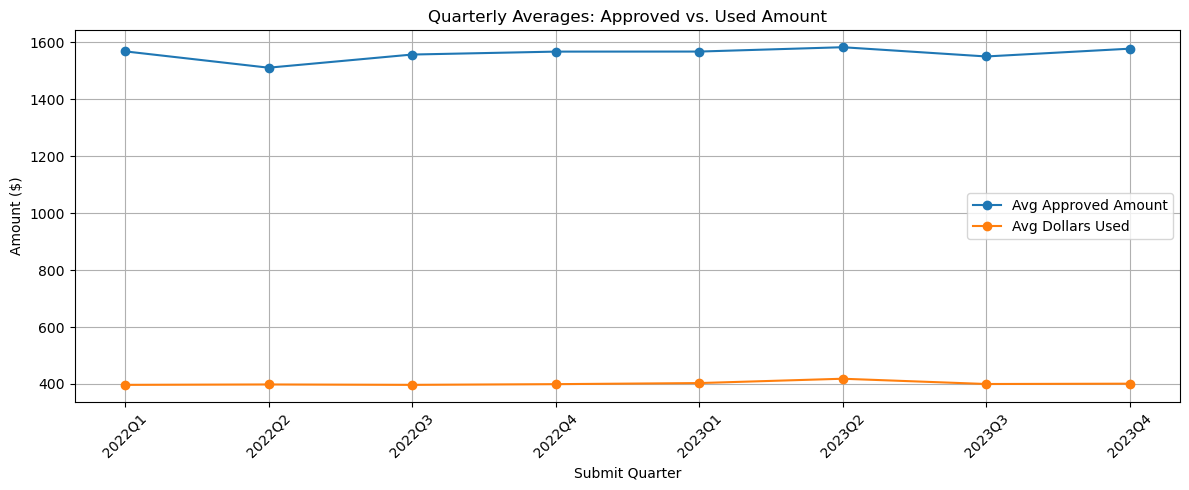

In [46]:
plot_average_trends(quarter_avg_df, "submit_quarter", "Quarterly Averages: Approved vs. Used Amount")


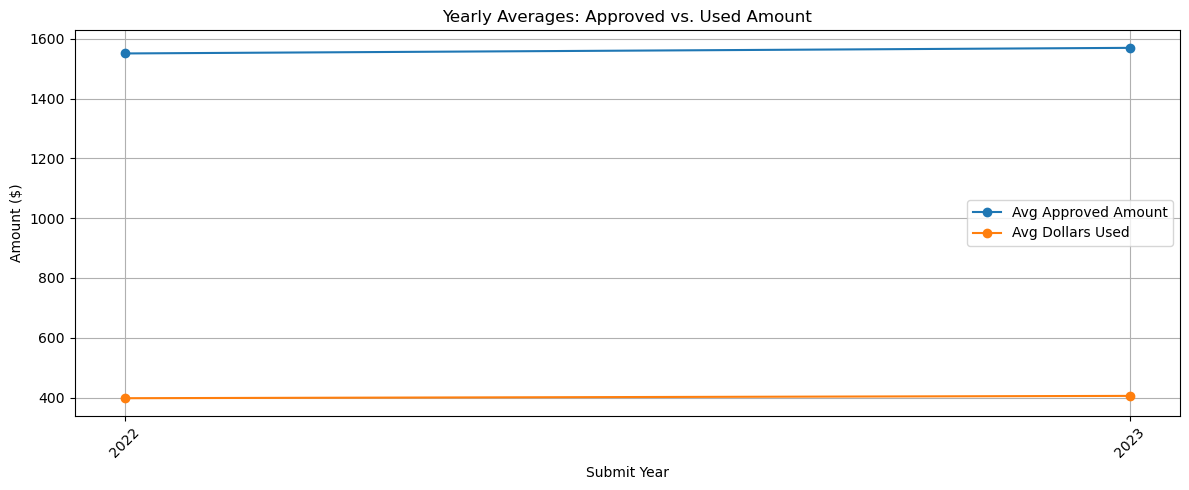

In [47]:
plot_average_trends(year_avg_df, "submit_year", "Yearly Averages: Approved vs. Used Amount")

-------BUSINESS INSIGHTS-------

The trends observed in these graphs are consistent with the earlier visualizations, reinforcing the previously identified patterns. As a result, the recommendations and insights shared earlier remain valid and actionable.

-------------------------------------------------------------------------------------------------------------------





Task 3 - Create a table to show possible metrics (e.g. number of applications, number of approved, approved amount, number of used apps, used amount, percentages, etc) by store.


Approach and Tooling:

Since this task involves structured table creation and metric calculation, I chose to use PostgreSQL as the backend database and SQL for querying.

Why PostgreSQL?

- Relational databases offer robust structure and indexing, making it easier to join, query, and aggregate across multiple related tables efficiently. 

- This makes them well-suited for BI tasks involving dimensions and facts

Implementation Steps:

- I pushed the cleaned and validated Pandas DataFrames (applications_df, customers_df, stores_df, and marketing_df) into PostgreSQL using the sqlalchemy package.

- After verifying table creation, all relevant store-level metrics were calculated directly within the Postgres database using SQL queries.

In [54]:
# Load variables from the .env file
load_dotenv(dotenv_path="credentials.env")

# Now use them like regular variables
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")

# Build connection string
conn_str = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
engine = create_engine(conn_str)


In [55]:
# Push to SQL (replace if already exists)
applications_df.to_sql("applications_fact", engine, index=False, if_exists="replace")
customers_df.to_sql("customers_dim", engine, index=False, if_exists="replace")
stores_df.to_sql("stores_dim", engine, index=False, if_exists="replace")
marketing_df.to_sql("marketing_dim", engine, index=False, if_exists="replace")

print("All DataFrames successfully pushed to PostgreSQL.")


All DataFrames successfully pushed to PostgreSQL.


A PostgreSQL table was created to evaluate store-level performance based on application and credit usage behavior. The following metrics were calculated for each store:

- store: Unique store identifier

- industry: Industry or sector of the store

- size: Store size

- location: State in which the store operates

- num_applications: Total number of applications submitted at the store

- num_approved_applications: Count of applications that were approved

- approval_rate: Percentage of applications approved

- total_approved_amount: Sum of approved credit amount

- total_used_amount: Total amount of credit actually used

- percent_used_amount: % of approved amount that was actually used

- num_used_applications: Count of approved applications that had any dollars used

`PostgreSQL SCRIPT

DROP TABLE IF EXISTS store_metrics_fact;

CREATE TABLE store_metrics_fact as
(SELECT 
    a.store,
    s.industry,
    s.size,
    s.state AS location,

    COUNT(*) AS num_applications,

    COUNT(CASE WHEN a.approved = TRUE THEN 1 END) AS num_approved_applications,
    ROUND(
        COUNT(CASE WHEN a.approved = TRUE THEN 1 END) * 100.0 / COUNT(*),
        2
    ) AS approval_rate,

    SUM(CASE WHEN a.approved = TRUE THEN a.approved_amount ELSE 0 END) AS total_approved_amount,
    SUM(CASE WHEN a.approved = TRUE THEN a.dollars_used ELSE 0 END) AS total_used_amount,

    ROUND((
        SUM(CASE WHEN a.approved = TRUE THEN a.dollars_used END) * 100.0
        / NULLIF(SUM(CASE WHEN a.approved = TRUE THEN a.approved_amount END), 0)
    )::NUMERIC, 2) AS percent_used_amount,

    COUNT(CASE WHEN a.approved = TRUE AND a.dollars_used > 0 THEN 1 END) AS num_used_applications

FROM applications_fact a
INNER JOIN stores_dim s ON a.store = s.store

GROUP BY a.store, s.industry, s.size, s.state
ORDER BY a.store);


-------------------------------------------------------------------------------------------------------------------









Task 4 - Create a view with a graph to compare the used dollars amount by Marketing name, and color by spend amount.

To achieve Task 4, a PostgreSQL view was created that calculated key metrics per campaign. This view was then used as a data source for Tableau visualizations to perform analysis.

The following metrics were calculated for each marketing campaign:

- campaign: Campaign name

- customers_per_campaign: Unique number of customers acquired through the campaign

- applications_per_campaign: Total applications submitted from those customers

- amount_spend_per_campaign: Total marketing spend for the campaign

- percent_of_total_spend: campaign spend as a % of total spend

- credit_approved_per_campaign: Total credit approved through to the customers obtained from a campaign

- credit_approved_pct_of_total: credit approved as a % of total

- credit_used_per_campaign: Total credit actually used by customers obtained from a campaign

- credit_used_pct_of_total: total credit used from this campaign

- credit_utilization_pct: % of approved credit that was actually used

- spend_utilization_per_million: Dollars used per a million (in dollars) in marketing spend

`PostgreSQL View

DROP VIEW IF EXISTS MARKETING_VIEW;

CREATE VIEW MARKETING_VIEW AS
(SELECT 
    m.name AS campaign,

    -- Volume metrics
    COUNT(DISTINCT c.customer_id) AS customers_per_campaign,
    COUNT(DISTINCT a.application_id) AS applications_per_campaign,

    -- Total spend by campaign
    SUM(m.spend) AS amount_spend_per_campaign,

    -- % of total marketing spend
    ROUND(
        (SUM(m.spend) * 100.0 / NULLIF(SUM(SUM(m.spend)) OVER (), 0))::NUMERIC,
        2
    ) AS percent_of_total_spend,

    -- Total credit approved (only for approved applications)
    SUM(CASE WHEN a.approved = 'TRUE' THEN a.approved_amount ELSE 0 END) AS credit_approved_per_campaign,

    -- % of total credit approved across all campaigns
    ROUND(
        (
            SUM(CASE WHEN a.approved = 'TRUE' THEN a.approved_amount ELSE 0 END) * 100.0 /
            NULLIF(SUM(SUM(CASE WHEN a.approved = 'TRUE' THEN a.approved_amount ELSE 0 END)) OVER (), 0)
        )::NUMERIC,
        2
    ) AS credit_approved_pct_of_total,

    -- Total dollars actually used
    SUM(a.dollars_used) AS credit_used_per_campaign,

    -- % of total dollars used across all campaigns
    ROUND(
        (
            SUM(a.dollars_used) * 100.0 /
            NULLIF(SUM(SUM(a.dollars_used)) OVER (), 0)
        )::NUMERIC,
        2
    ) AS credit_used_pct_of_total,

    -- What % of approved credit was actually used (per campaign)
    ROUND(
        (
            SUM(a.dollars_used) * 100.0 /
            NULLIF(SUM(CASE WHEN a.approved = TRUE THEN a.approved_amount ELSE 0 END), 0)
        )::NUMERIC,
        2
    ) AS credit_utilization_pct,

    -- How many dollars used per million dollar of marketing spend
    ROUND(
        (
            (SUM(a.dollars_used) * 1.0) / NULLIF(SUM(m.spend), 0) * 1000000
        )::NUMERIC,
        2
    ) AS spend_utilization_per_million

FROM applications_fact a

-- Join each application to the customer and marketing campaign

JOIN customers_dim c ON a.customer_id = c.customer_id
JOIN marketing_dim m ON m.id = c.campaign

-- Limit to applications that occurred during the campaign's active period

WHERE a.submit_date BETWEEN m.start_date AND m.end_date

-- Group by campaign

GROUP BY m.name);




TABLEAU VISUALIZATION (CREDIT USED PER CAMPAIGN ALONG WITH SPEND PER CAMPAIGN)

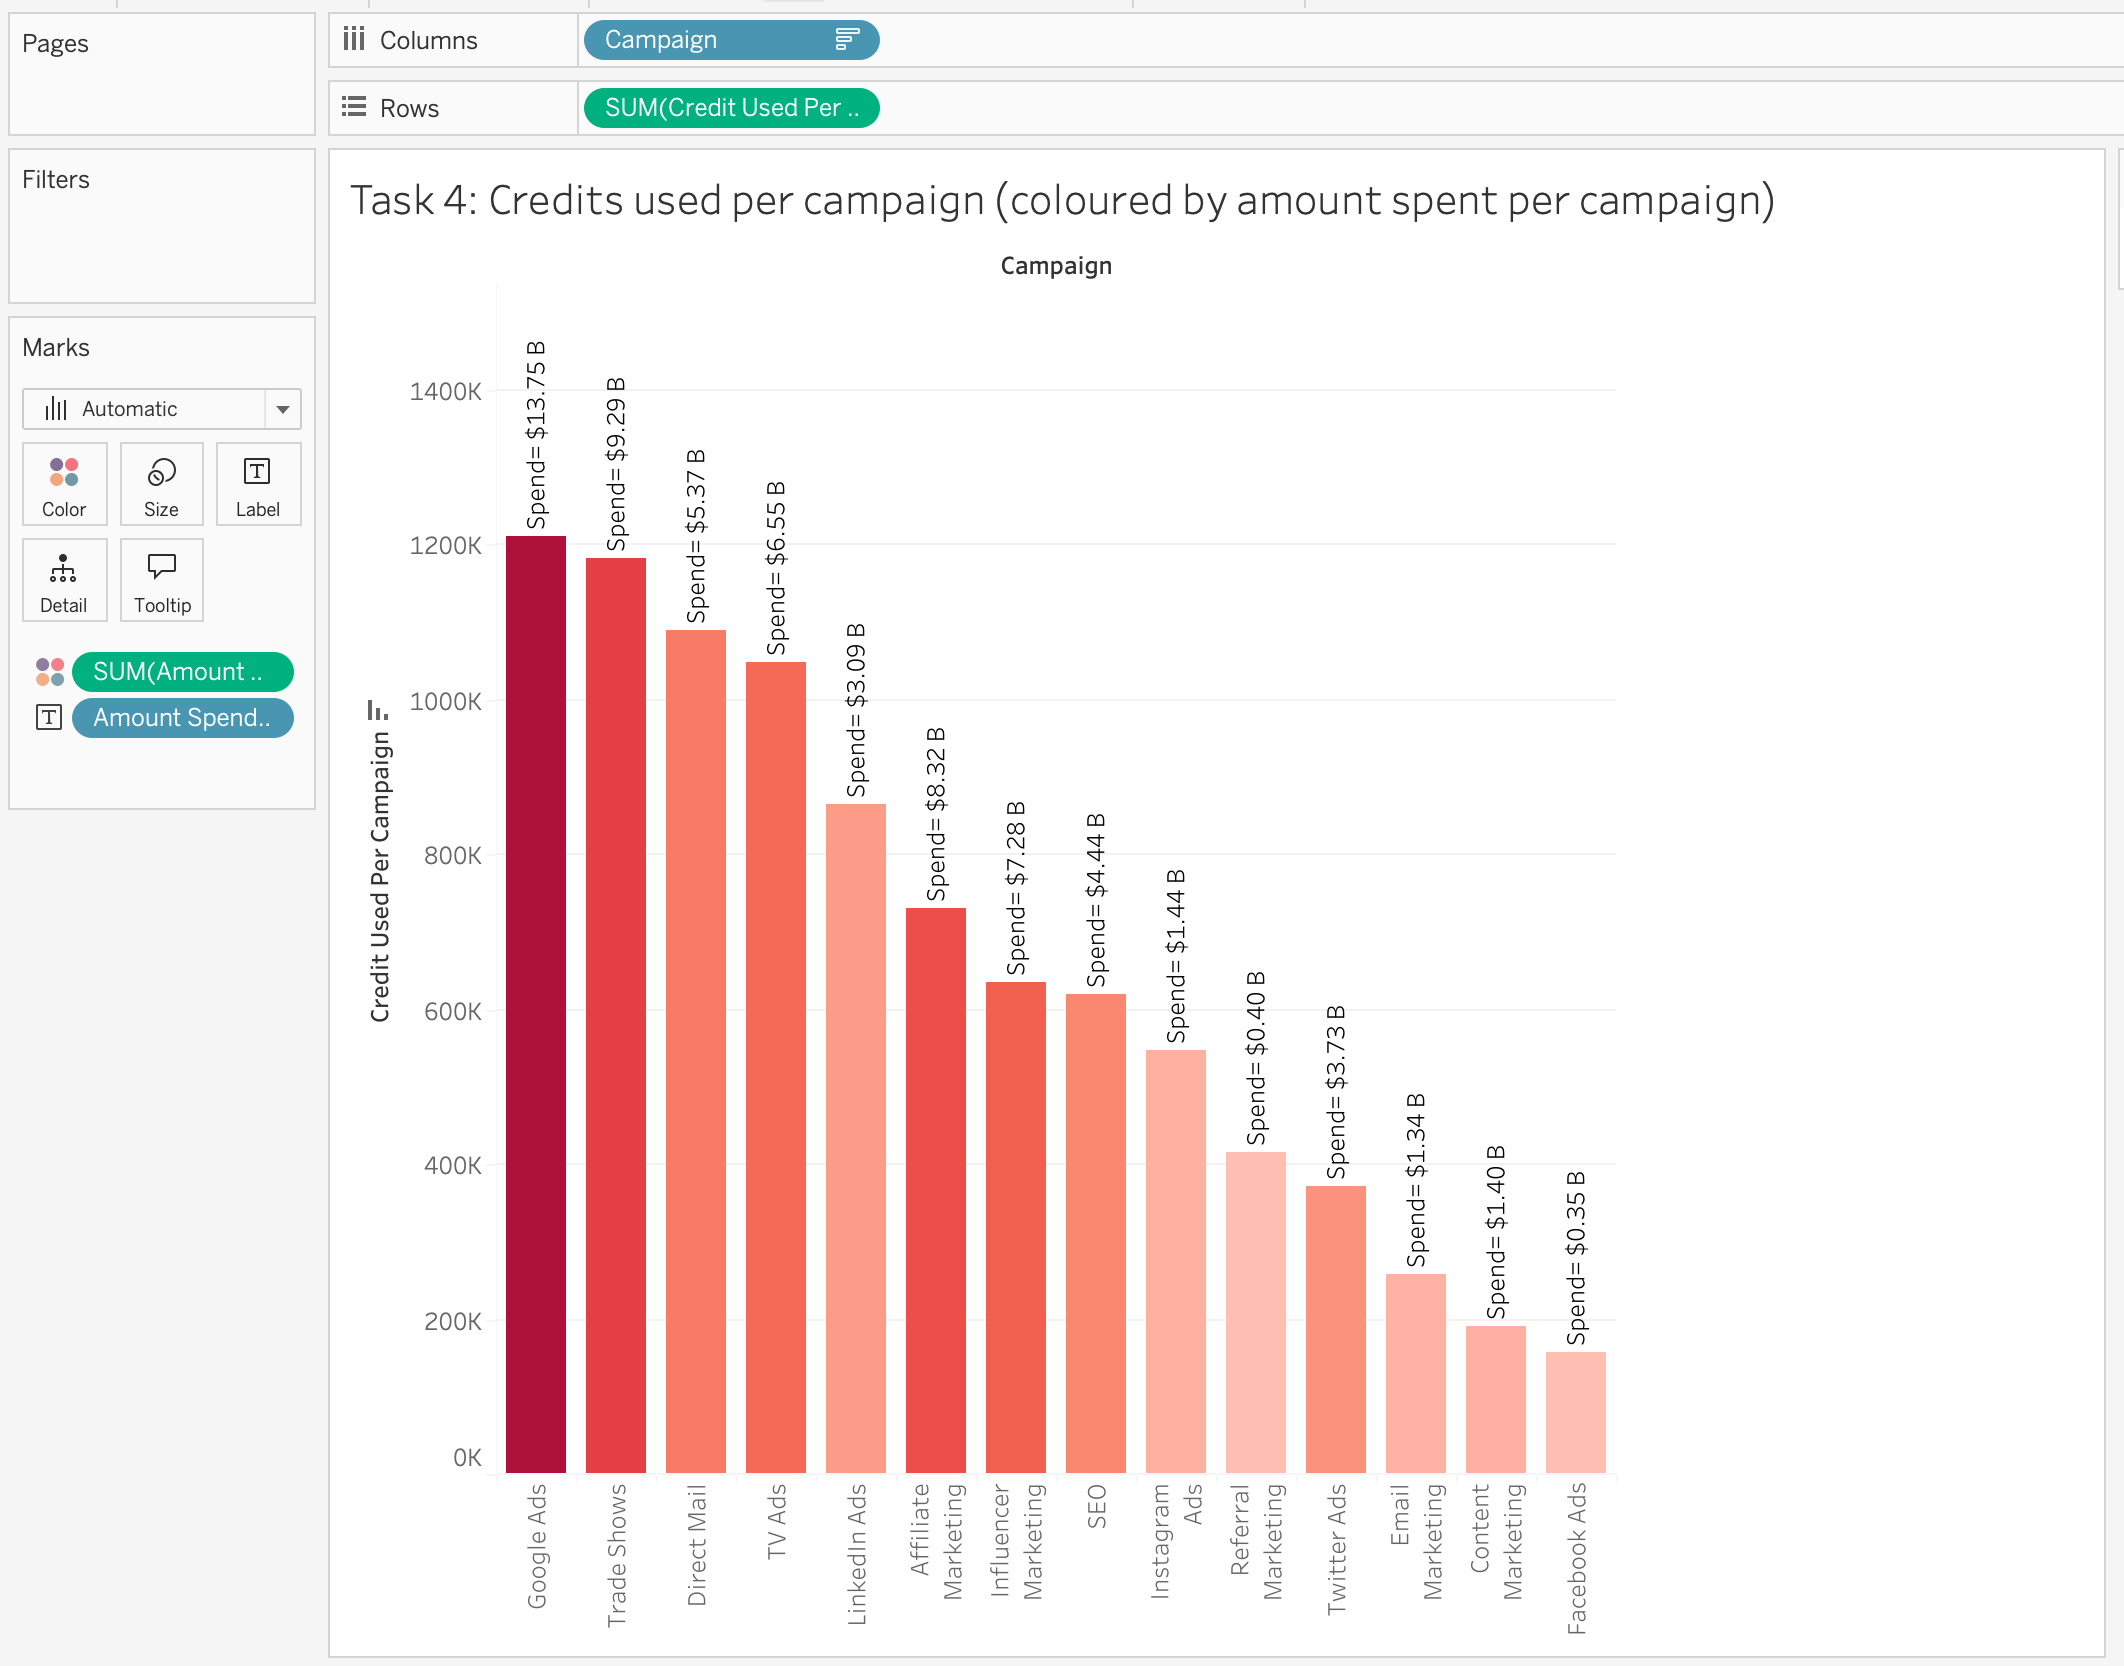

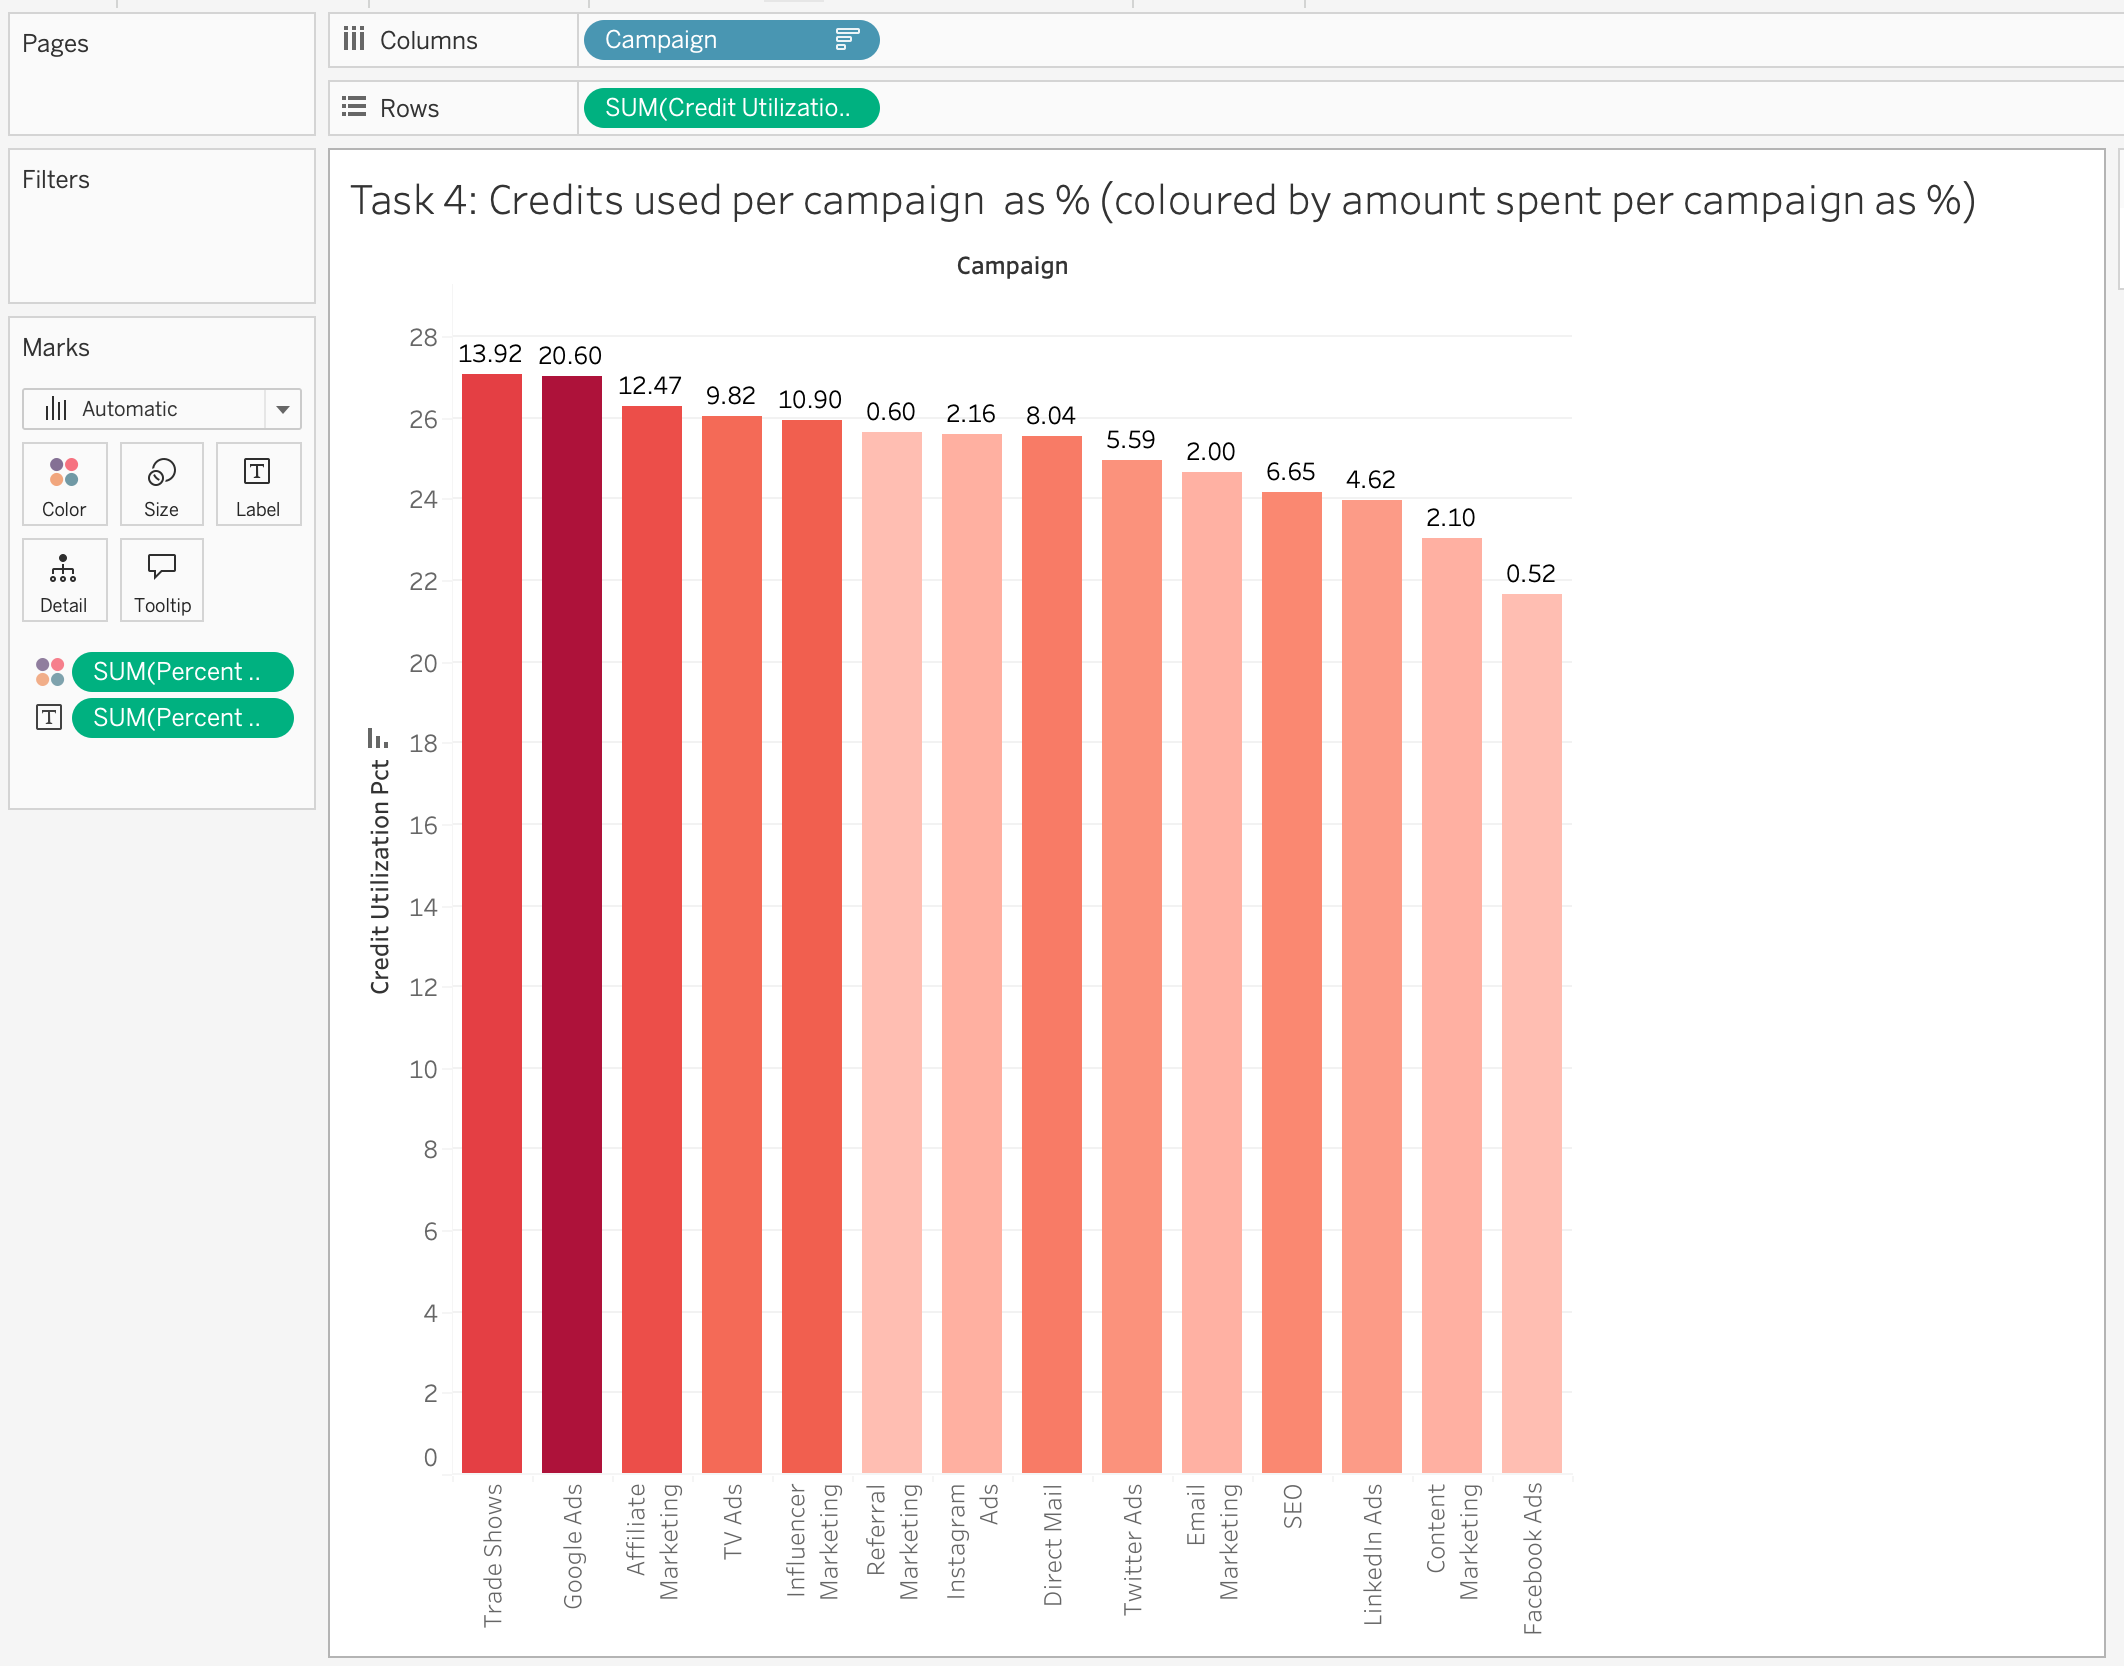

Business Insight:

Trade Shows stands out as the most effective marketing channel with highest total credit used, indicating a strong utilization rate. This suggests that budget allocated to Trade Shows is being converted into actual credit usage more efficiently than any other channel.







-------------------------------------------------------------------------------------------------------------------

Task 5 - Come up with something interesting with the data to share with us. Keep in mind this is randomly generated sample data so trends may or may not be present, but don’t let that hold you back.



Business Problem 1:

Why is the utilization rate very low. Is their periodic drop off at different points in the financing funnel indicating good validations across each stage


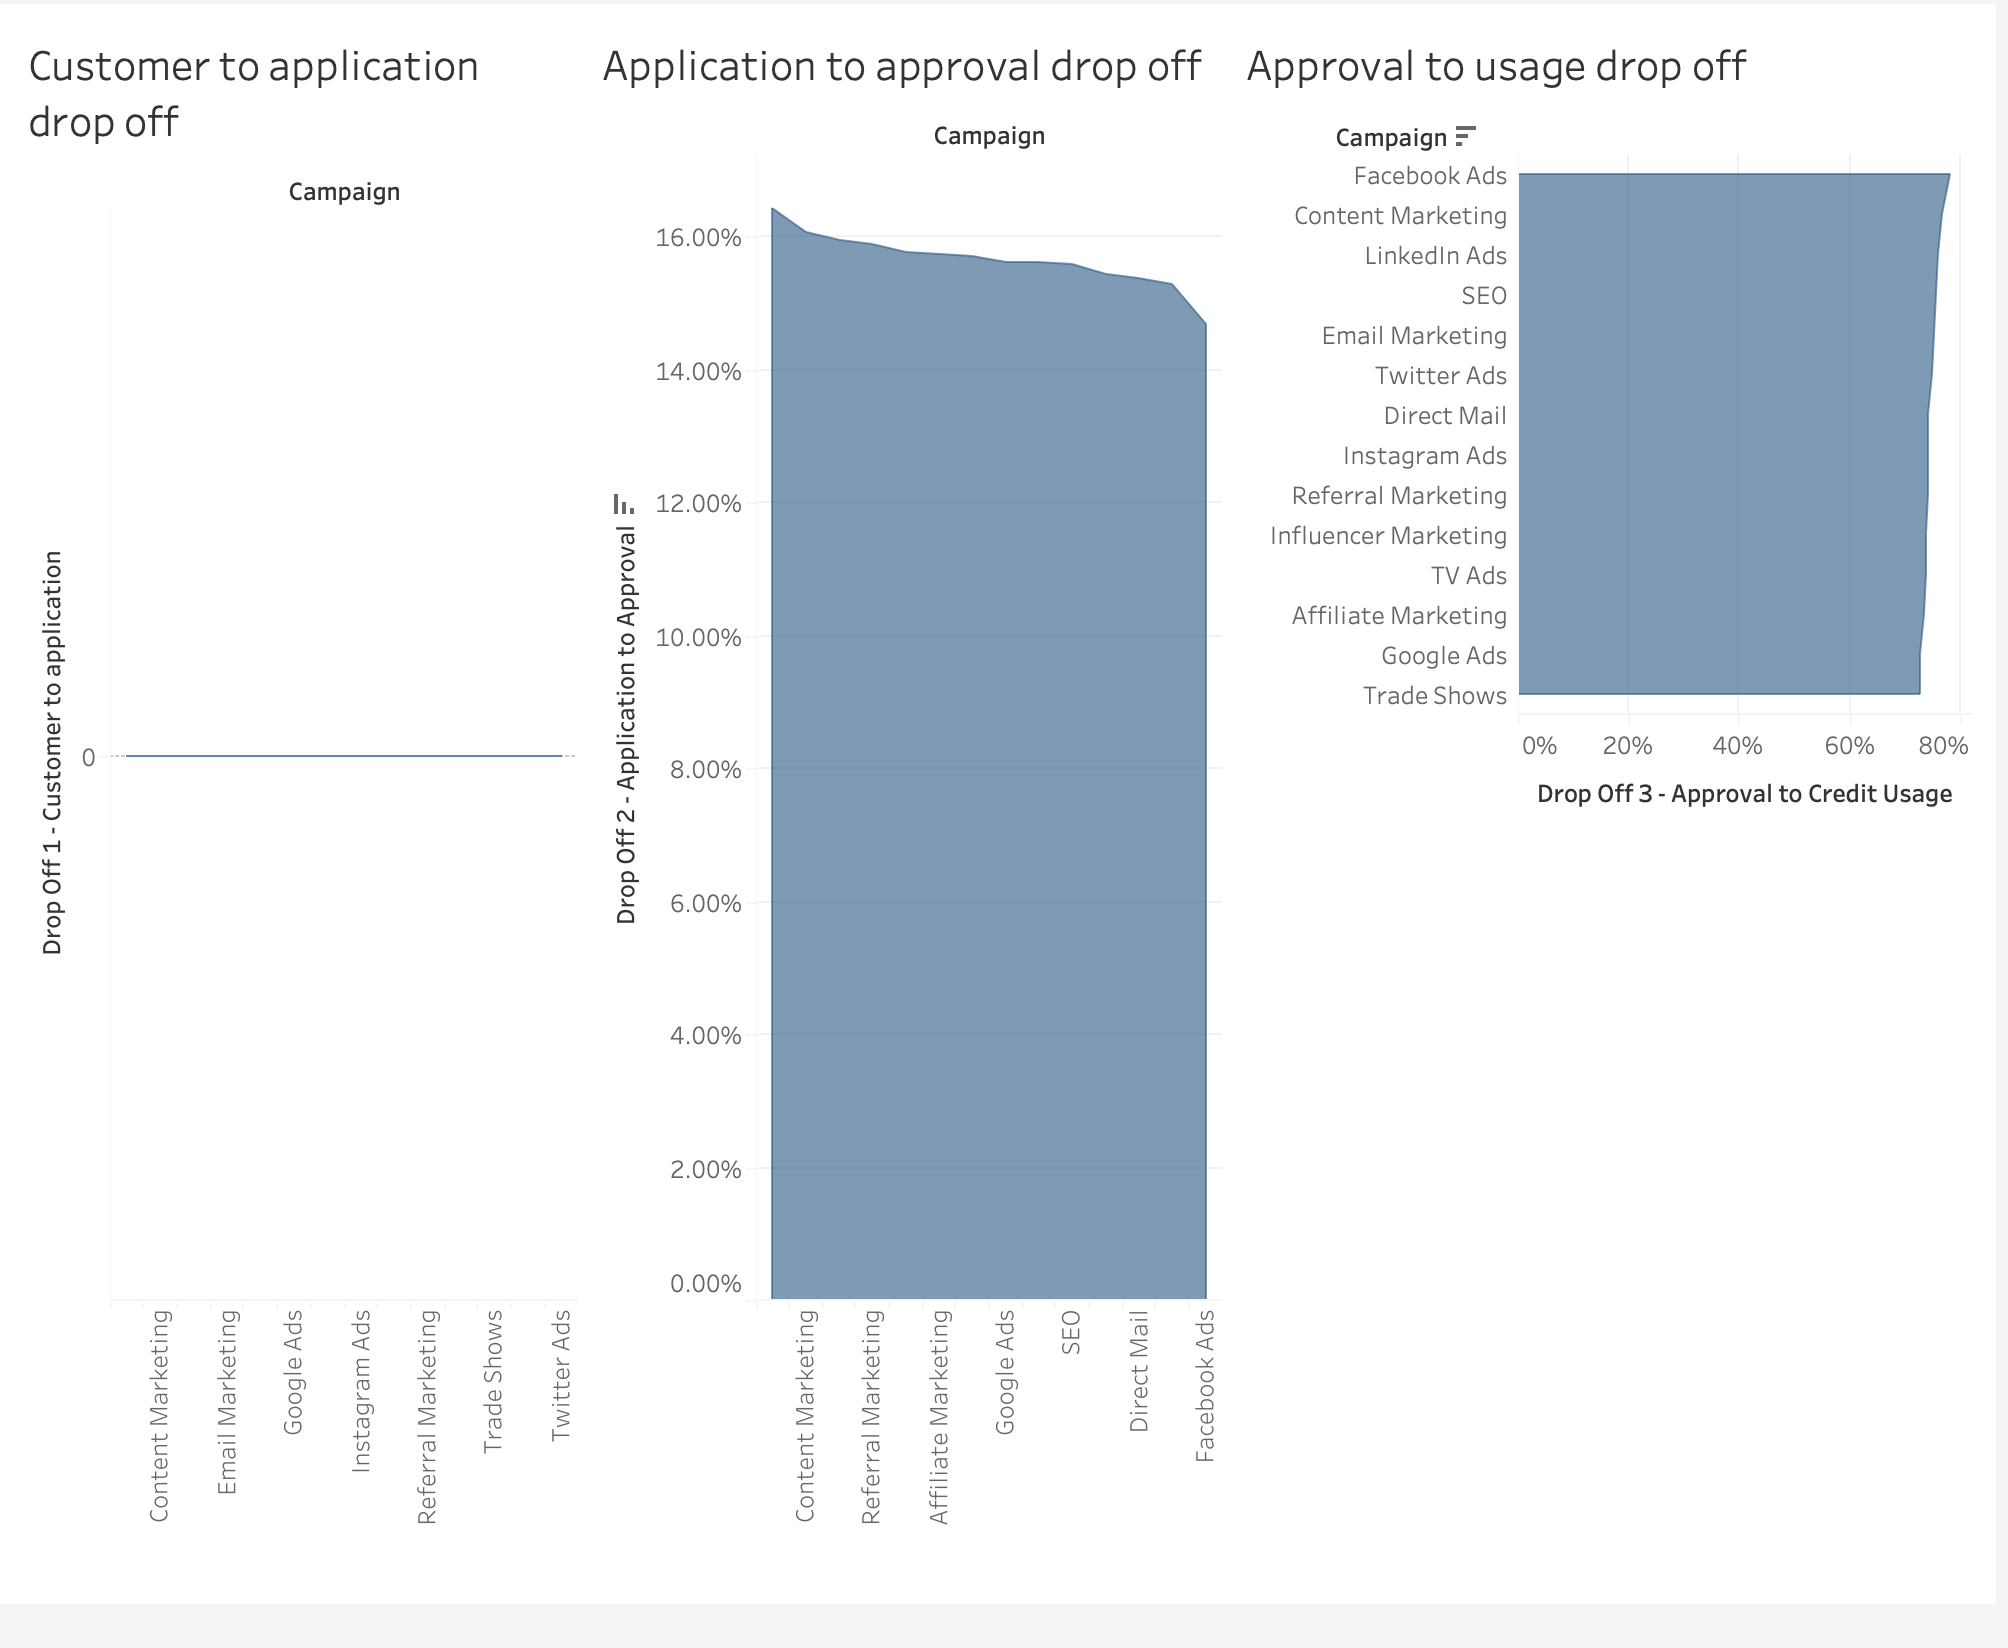

Steps followed:

- Investigated how users moved through 3 key stages across campaigns:

    - From customer acquisition to application

    - From application to approval

    - From approval to actual credit usage

Stage 1: Customer → Application

There was almost no drop-off here. Most customers who were acquired actually went on to submit an application — a good sign that campaigns are targeting interested users.

Stage 2: Application → Approval

We saw a small drop-off here (~15%). This means most applicants are getting approved. While that sounds great on the surface, some level of drop-off is healthy which indicates that the screening process in place.

Stage 3: Approval → Usage

This is where we saw the biggest drop-off. About 25% of approved users didn’t use their credit. But iwhat was interesting or a concern was that this pattern was similar across most campaigns, and usage rates were still relatively high (70–78%).

Recommendations:

Maintain filtering at each stage — especially during approvals. Don’t aim for 100% approval just to push volume.





Business Problem 2: 

While it's great that customers are being approved for credit, it was important to address high levels of unused approved credit which could mean customers aren’t following through, or even worse, the campaign isn’t attracting and Snap isnt approving the right kind of users.

This was in extension to the problem that was analyzed as part of Task 4.

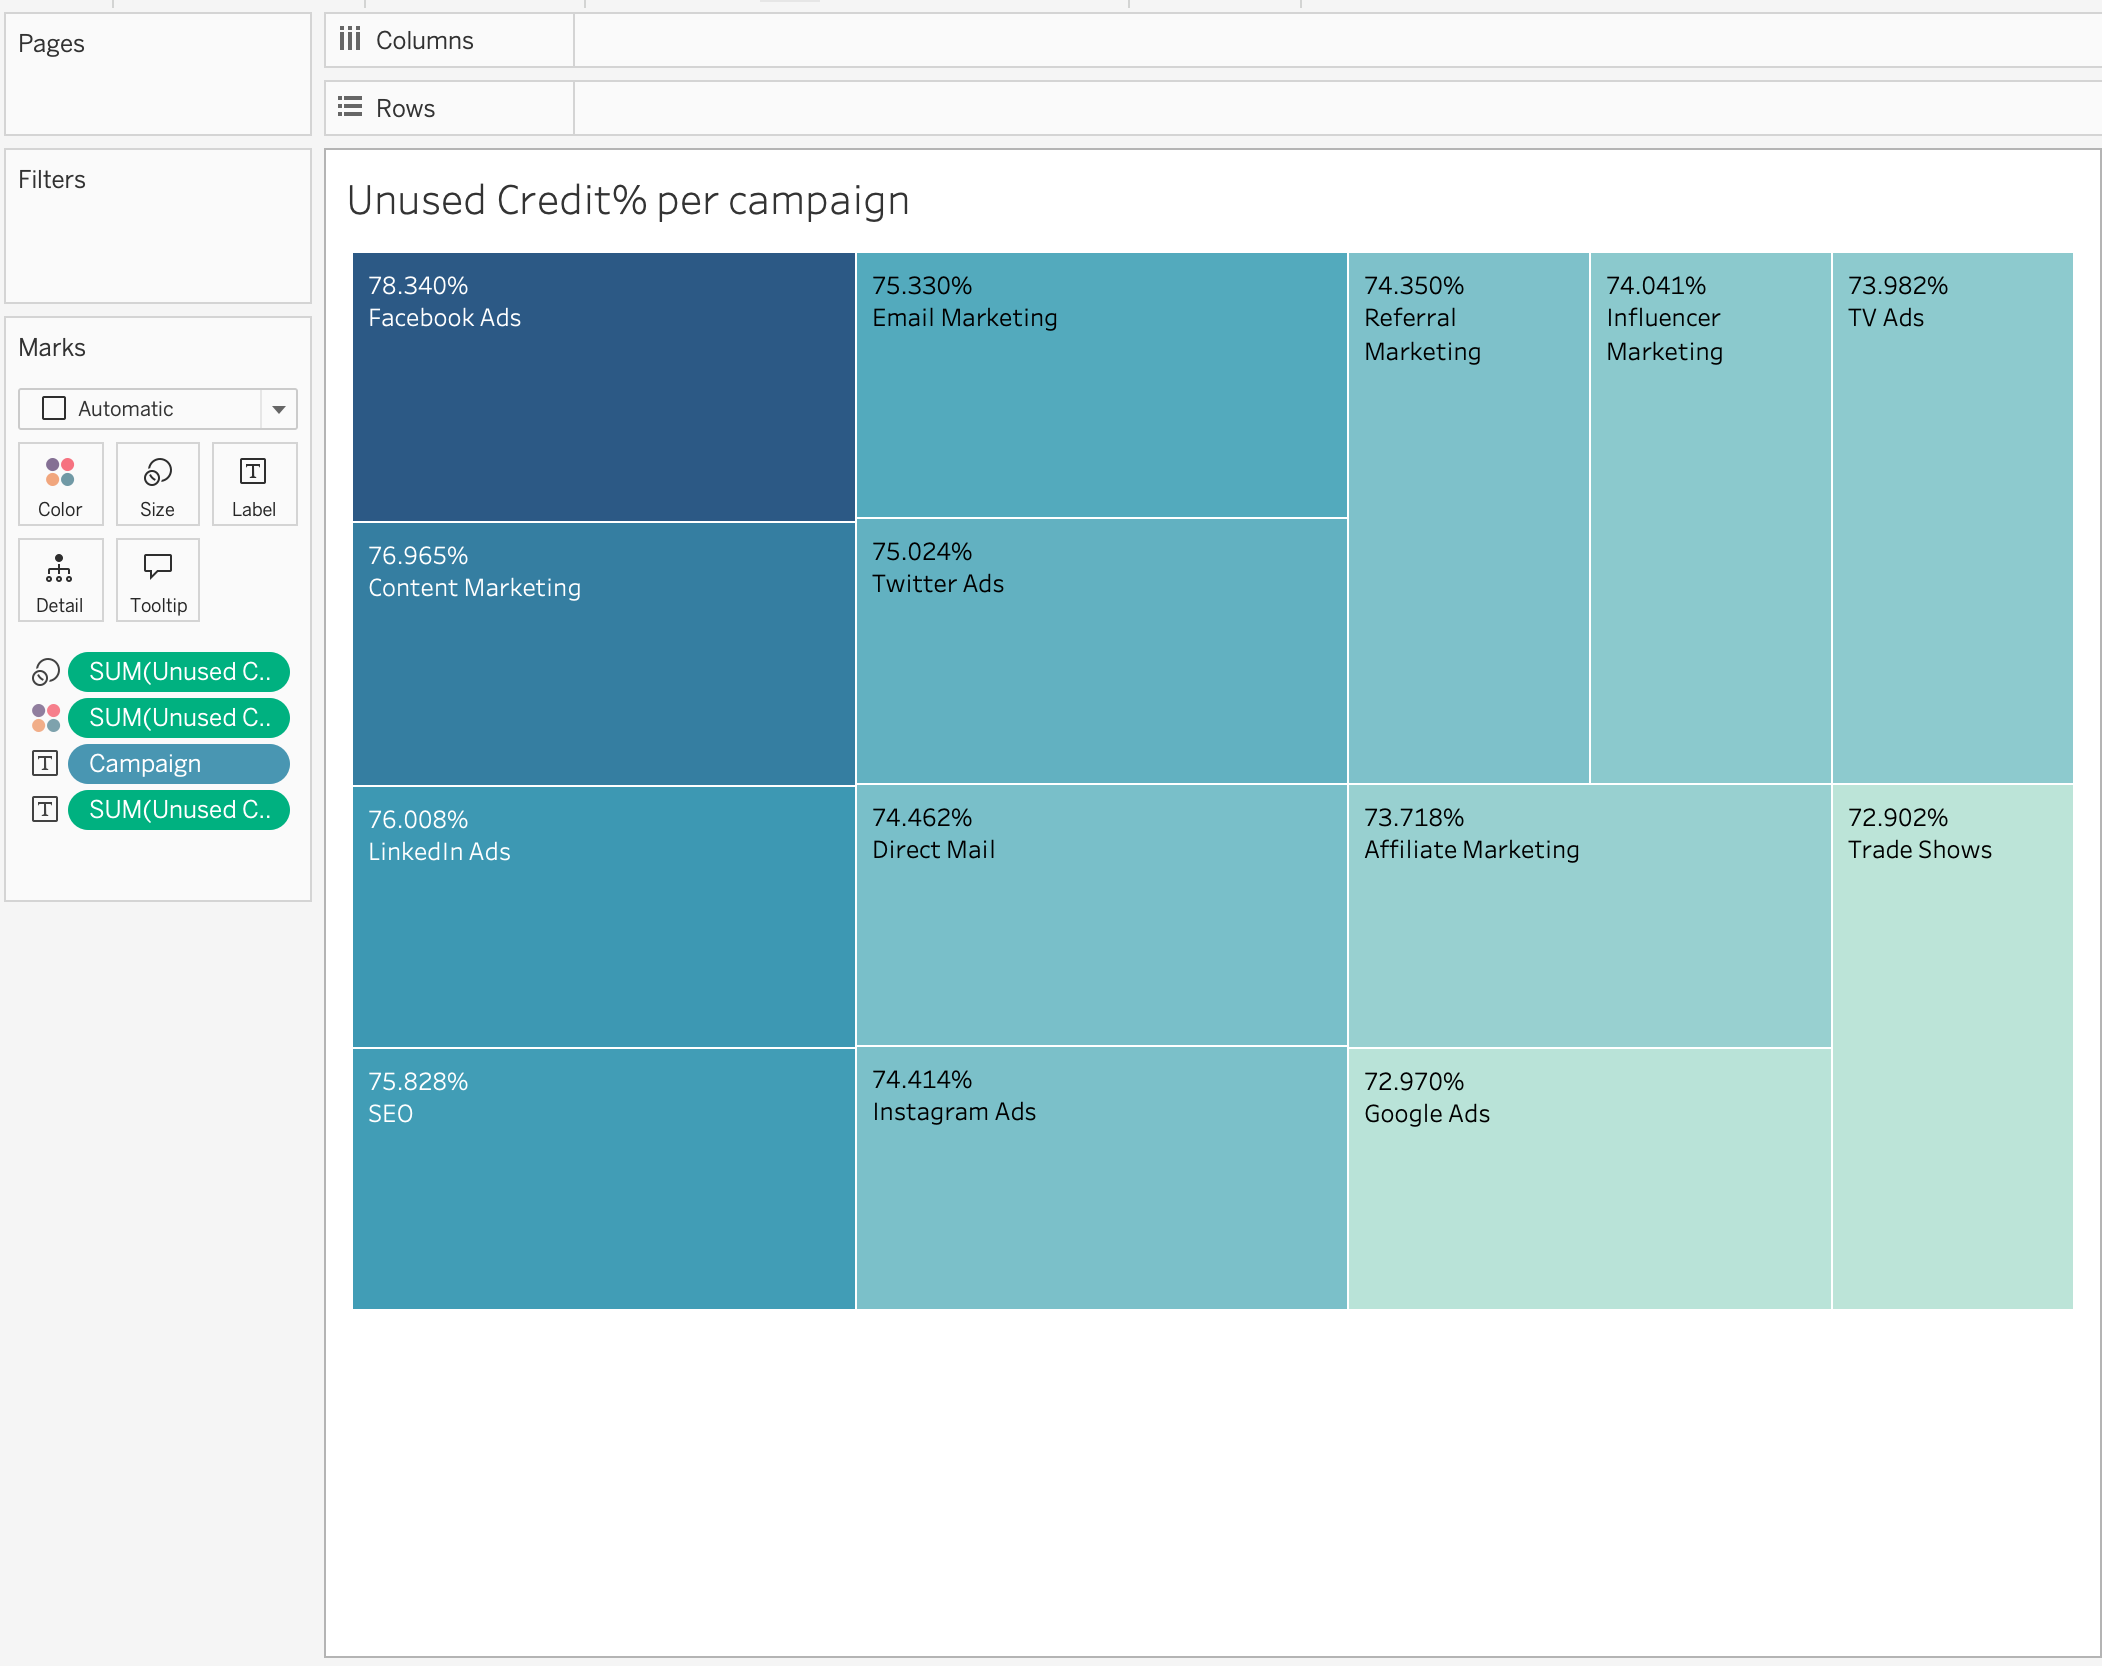



Insight:

- This treemap displays the percentage of approved credit that went unused, broken down by campaign. Each block shows the campaign name and its corresponding Unused Credit %.

- Across the board, every campaign had at least 70% of its approved credit go unused.

- Facebook Ads had the highest unused credit % at 78.34%, followed closely by Email and Content Marketing.

- This further suggests that

    - It’s possible that customers are getting approved too easily, then losing interest or not understanding the next steps.


Recommendations:

- Introduce post-approval nudges: Send reminders, limited-time offers, or education on how to use approved credit 

- Add urgency post-approval: Try messaging like “Your credit is waiting – use within 7 days” to boost conversion.






Additional Insight:

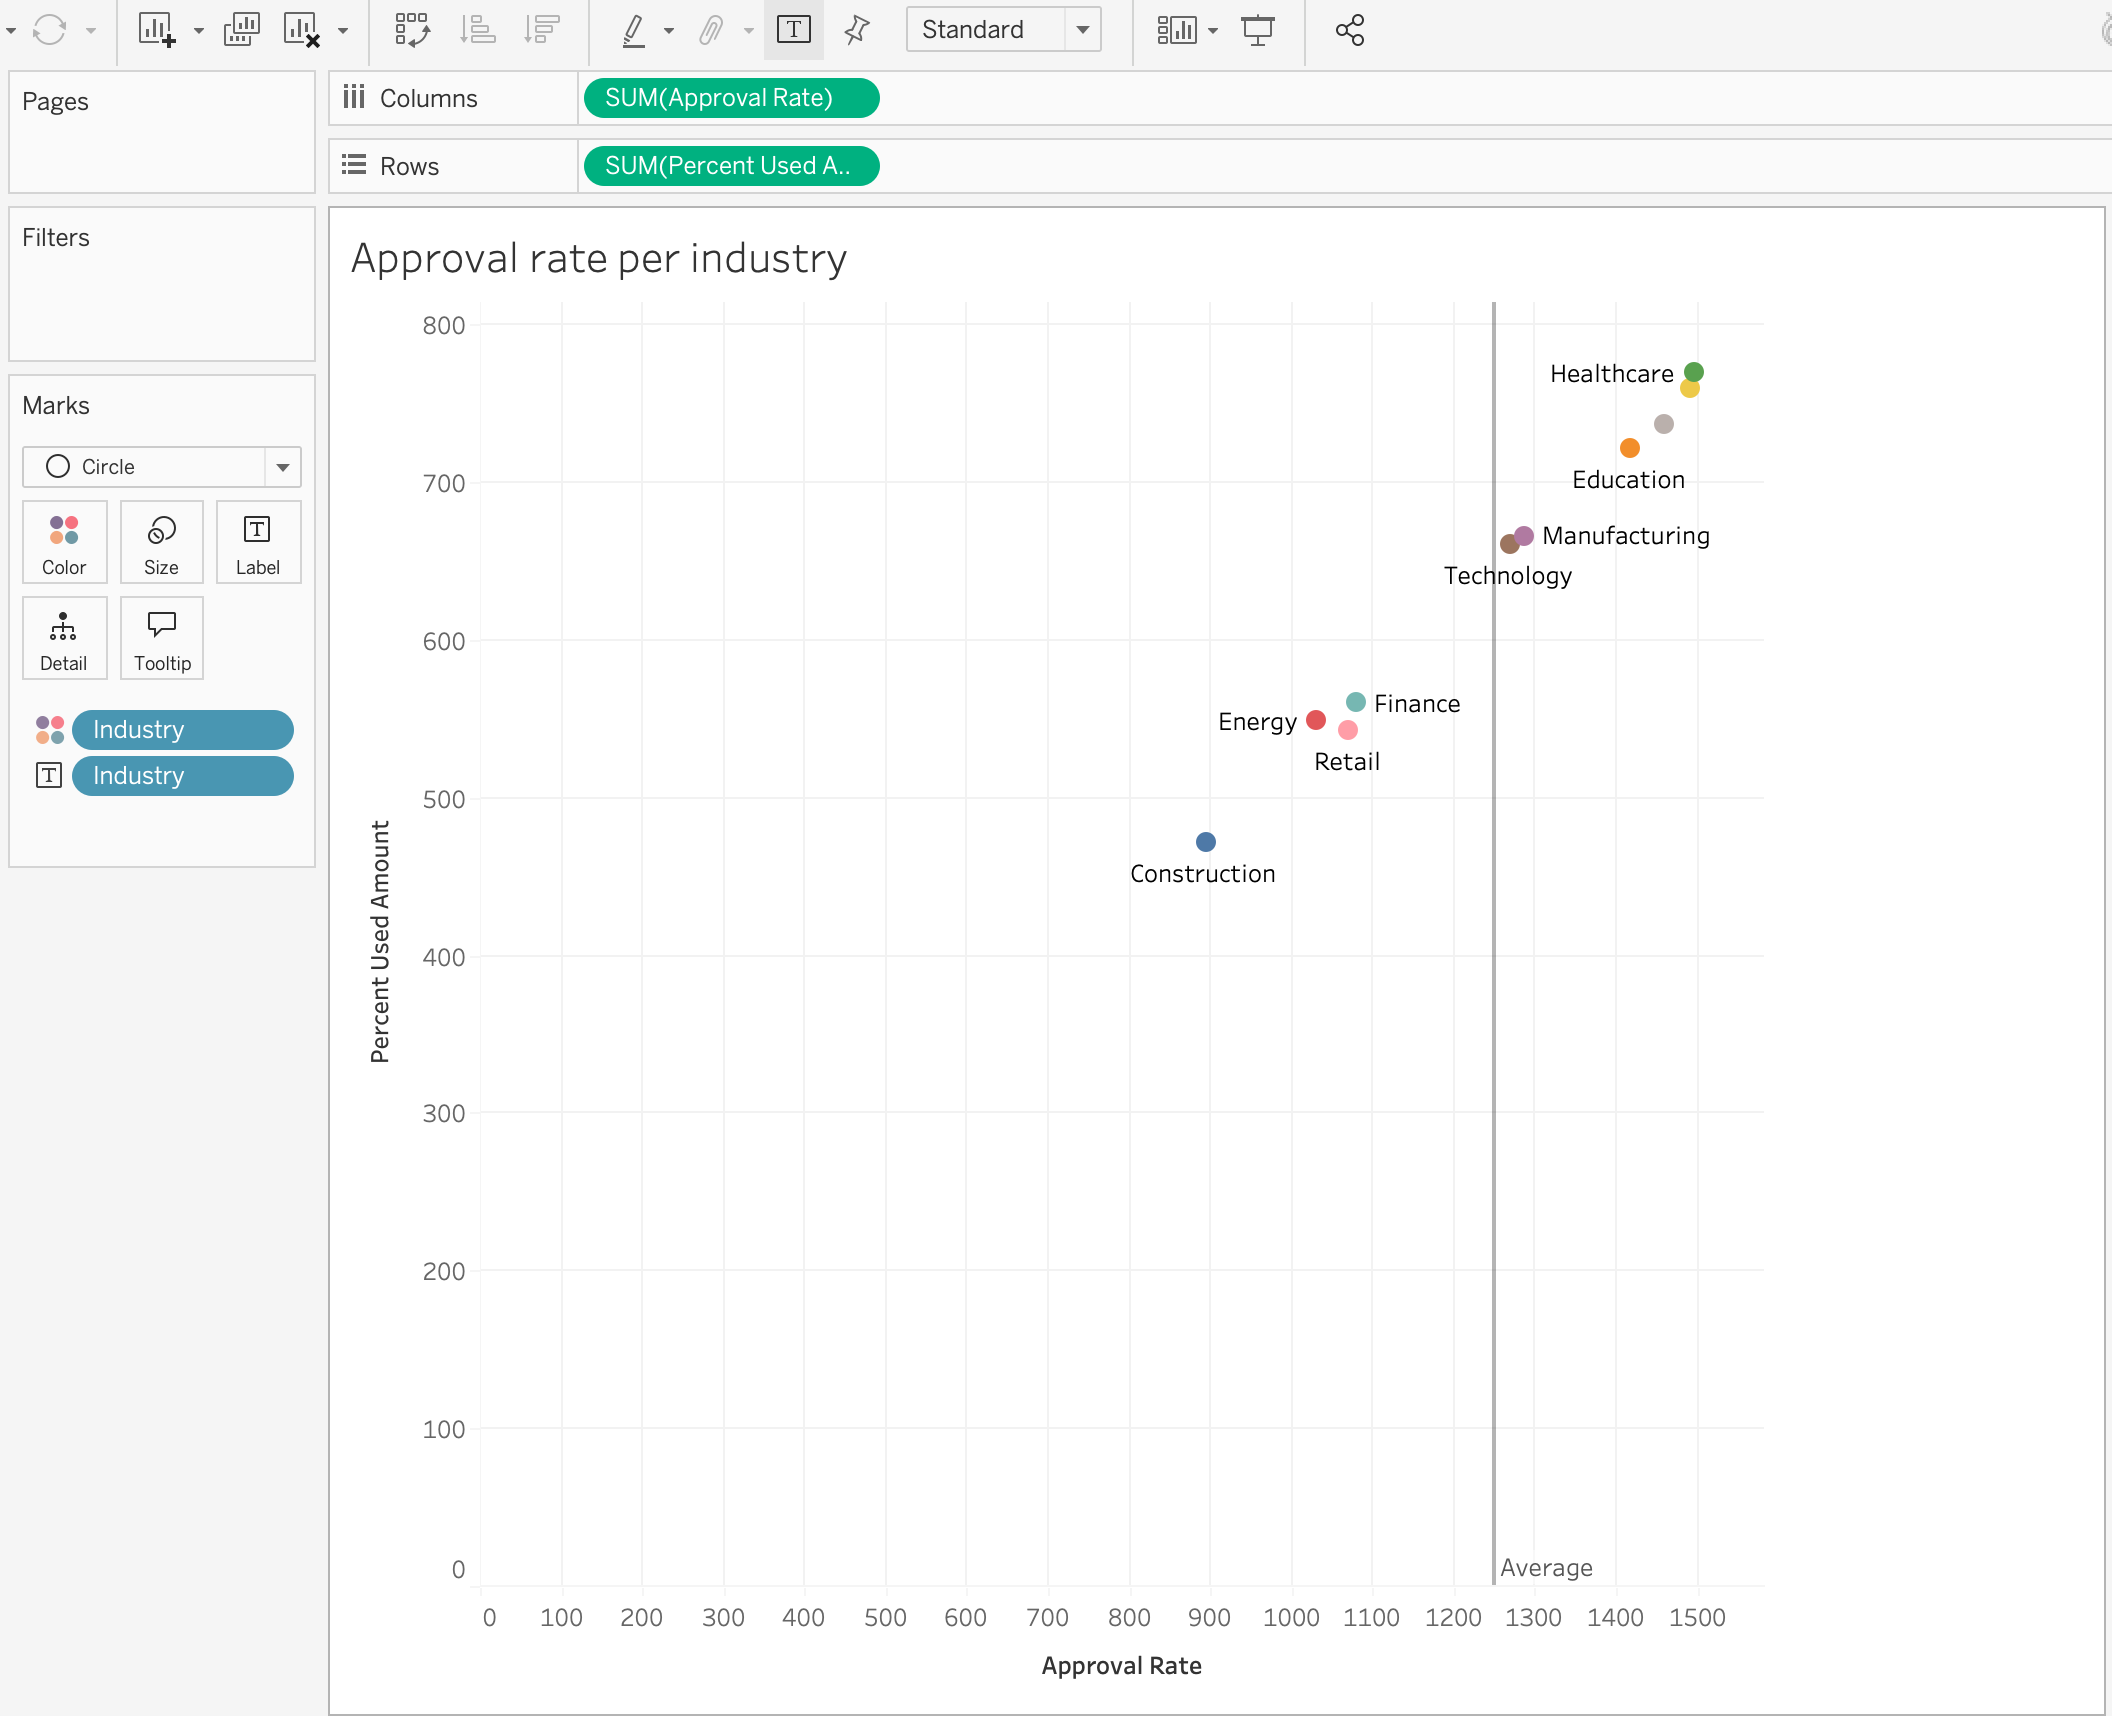


- Industries like Healthcare and Education show a healthy balance — they approve a high number of applications, and most of that credit gets used.

- However, industries such as Retail, Finance, and particularly Construction are clustered below the average in terms of usage, despite relatively high approval rates. This suggests that these industries may be approving more customers than necessary, and those approvals aren’t turning into actual usage.


---THANK YOU---